<a href="https://colab.research.google.com/github/MaorKer/Wiezmann_ML_Course/blob/master/Maor_Kereth_Homework_3_shortest_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

Using backend: pytorch


In [1]:
!pip install dgl

     |████████████████████████████████| 3.0MB 13.1MB/s 


# Homework 3 - finding shortest path (edge classification)

### The data here is stored in 10,000 json files for each of the training/testing datasets

In [2]:
path_to_ds = '/content/drive/My Drive/ML Weizmann/training_data'
path_to_test_ds = '/content/drive/My Drive/ML Weizmann/test_data'

### the custom dataset object will load the json files, and then convert the graphs to DGL graphs

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph,node_attrs=['node_features'],edge_attrs=['distance','on_path'])
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx], self.graphs[idx].edata['on_path']

### The node features are just 2 numbers - [0,0] for most nodes,
### and [1,0] for the start node, [0,1] for the end node
### the edges all have a property of "distance" which is essentially random
### and a label if they are on the shortest path or not

In [8]:
train_ds = CustomDataset(path_to_ds)


KeyboardInterrupt: ignored

In [13]:
test_ds = CustomDataset(path_to_test_ds)

KeyboardInterrupt: ignored

In [5]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
f = open('train_ds.pkl', 'train_ds')  # Python 3: open(..., 'wb')
pickle.dump(obj, f)
f.close()


ValueError: ignored

In [11]:
train_ds[495]

(DGLGraph(num_nodes=21, num_edges=84,
          ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32)}
          edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.int64)}),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]))

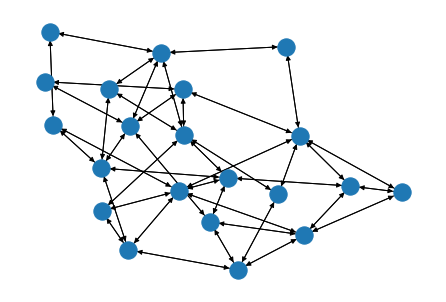

In [13]:
nx.draw( dgl.to_networkx(train_ds[495][0]) )

In [14]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['node_features'],edge_attrs=['distance'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [60]:
import torch.nn as nn
import torch.nn.functional as F


#this function is the edge update function - 

class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()

        self.seq = nn.Sequential(nn.Linear(25,35), nn.ReLU() , nn.Linear(35,50) ,nn.ReLU())  
        
    def forward(self, x):

        
        united_tensor=torch.cat((x.dst['node_features'],x.dst['node_hidden_state'],x.src['node_features'],x.src['node_hidden_state'],torch.unsqueeze(x.data['distance'],1)),1)

        output=self.seq(united_tensor)
        


        return {'edge hidden represetation': output }

class NodeNetwork(nn.Module):
    def __init__(self):
        super(NodeNetwork, self).__init__()
       

        self.nodes_FTW=nn.Sequential(nn.Linear(62,40) , nn.ReLU() , nn.Linear(40,10) , nn.ReLU() )
        
    def forward(self, x):

        email_not_fax=x.mailbox['edge hidden represetation'].sum(dim=1)
        TOTAL_VECTOR_GG=torch.cat((x.data['node_hidden_state'],x.data['node_features'],email_not_fax),1)
        # return a new hidden state for the node
        out=self.nodes_FTW(TOTAL_VECTOR_GG)

        

        return {'node_hidden_state': out }





class EdgeNetwork_CLASS(nn.Module):
    def __init__(self):
        super(EdgeNetwork_CLASS, self).__init__()

        self.seq_only_with_class=nn.Sequential(nn.Linear(25,15), nn.ReLU() , nn.Linear(15,5) ,nn.ReLU() , nn.Linear(5,1) ,nn.ReLU())  
        
    def forward(self, x):

        
        united_tensor=torch.cat((x.dst['node_features'],x.dst['node_hidden_state'],x.src['node_features'],x.src['node_hidden_state'],torch.unsqueeze(x.data['distance'],1)),1)

        output=self.seq_only_with_class(united_tensor)
        


        return {'edge hidden represetation': output }

    


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.node_init = nn.Sequential(nn.Linear(2,5) , nn.ReLU() , nn.Linear(5,10) , nn.ReLU() )
        
        self.edge_network = EdgeNetwork()
        self.node_network = NodeNetwork()
        
        self.edge_classifier = EdgeNetwork_CLASS()
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['node_features'])
        
        for i in range(10):
            
            g.update_all(self.edge_network,self.node_network)
            
        
        #we want to classify the edges - so finally apply your edge classifier -
        g.apply_edges(self.edge_classifier)
        
        #and extract its output 
        out = g.edata['edge_class_prediction']

        
        return out 

In [61]:
net = Classifier()

In [62]:
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)
n_epochs = 15

# for epoch in 
#     for x,y in data_loader:
        
#         x = x.to(torch.device('cuda'))
#         y = y.cuda()
for epoch in tqdm(range(n_epochs)):
    
    net.train()
    for x,y in data_loader:
        
        optimizer.zero_grad()
        output = net(x)
        loss = loss_func(output,y)    
        loss.backward()
        optimizer.step()
    net.eval()           
        



KeyError: ignored

In [ ]:
for epoch in tqdm(range(n_epochs)):
    
    net.train()
    for x,y in data_loader:
        
        optimizer.zero_grad()
        output = net(x)
        loss = loss_func(output,y)    
        loss.backward()
        optimizer.step()
    net.eval()  

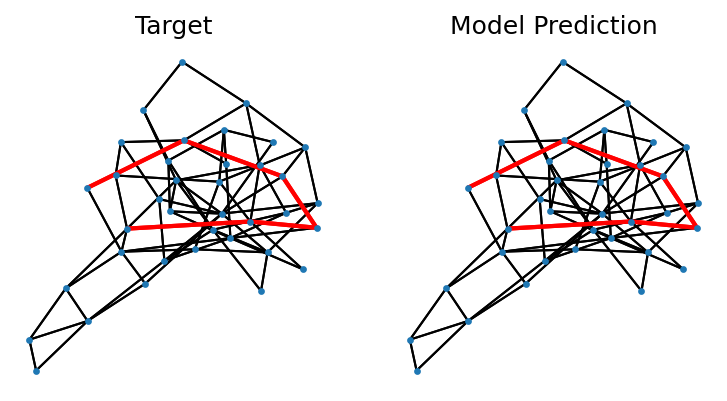

In [ ]:
from scipy.special import expit, logit

fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].set_title('Target')
ax[1].set_title('Model Prediction')

net.eval()
net.cpu()

dgl_g = test_ds[5578][0]

output_pred = net(dgl_g).data.numpy()

nx_graph = dgl.to_networkx(dgl_g)
pos = {i: dgl_g.ndata['node_features'][i][:2].data.numpy() for i in range(len(dgl_g.ndata['node_features']))} #nx.spring_layout(nx_graph)
edge_list = [e for i,e in enumerate(nx_graph.edges) if dgl_g.edata['on_path'][i]==1]

edge_widths = np.array([expit(output_pred[i][0]) for i in range(len(output_pred))])
predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if expit(output_pred[i])[0]>=0.5]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

plt.show()

### Once you train your network - 
### you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,
### most of the edges in the dataset have a label 0, so its quite easy to reach a high true negative rate
### but train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

In [ ]:
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)

In [ ]:
net.eval()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
total_positives = 0
total_negatives = 0

for i, (x,y) in enumerate(test_data_loader):
        
        y = y.data.numpy()

        prediction = net(x).cpu().data.numpy()
        
        prediction[prediction >= 0.5] = 1
        prediction[prediction <0.5] = 0
        
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        
        true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
        true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
        false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
        false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
print(true_positive/total_positives)
print(false_negative/total_positives)
print(true_negative/total_negatives)
print(false_positive/total_negatives)